In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import testing as test
import graph_visualization as gv

# 1

In [44]:

# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
# with open(read_json_path)  as json_file:
#     raw_json = json.load(json_file) # returns json file as dict

# graph = sg.StackedGraph(raw_json=raw_json)

# subgraphs = list(dijk.graph_partition(graph))
# dijk.select_nodes(graph, subgraphs)


In [45]:
# groups = list(graph.get_node_groups(ASAP = False))
# print(test.group_validate(graph, groups))
# for group in groups:
#     print(group)


In [46]:
# n_graphs = len(groups)
# n_cols = 6  # Number of columns for the grid
# n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
# axes = axes.flatten()  # Flatten the array of axes


# for i in range(len(groups)):
#     if i >= 0:
#         test_group = groups[i]

#         start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
#         first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
#         first_stack.parents = [0]

#         subgraph_stack_list = [start_stack, first_stack]
#         for stack_id in test_group[1:]:
#             stack = graph.stack_list[graph.id_to_idx[stack_id]]
#             new_node = copy.deepcopy(stack)
#             new_node.parents = set(new_node.parents) - graph.load_nodes
#             subgraph_stack_list.append(new_node)


#         new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
#         # gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')
#         # gv.adj_to_graph(new_graph, save=False, layout = 'kk', title = f'Subgraph {i}')
#         gv.adj_to_graph(new_graph, ax=axes[i], layout='kk', title=f'Subgraph {i+1}')


# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])


# plt.tight_layout()
# plt.show()


# 2

In [10]:
subgraph_to_plot = 3

read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict
graph = sg.StackedGraph(raw_json=raw_json)


subgraphs = list(dijk.graph_partition(graph))
dijk.select_nodes(graph, subgraphs)

In [11]:
def draw_subgraphs(graph, sub='all'):
    subgraphs = list(dijk.graph_partition(graph))
    dijk.select_nodes(graph, subgraphs)

    if sub == 'all':
        n_graphs = len(subgraphs)
        n_cols = 6  # Number of columns for the grid
        n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
        axes = axes.flatten()  # Flatten the array of axes

        for i in range(len(subgraphs)):
            gv.adj_to_graph(subgraphs[i], ax=axes[i], layout='kk', title=f'Subgraph {i+1}')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        gv.adj_to_graph(subgraphs[sub], ax=ax, layout='kk', title=f'Subgraph {sub}')


    plt.tight_layout()
    plt.show()

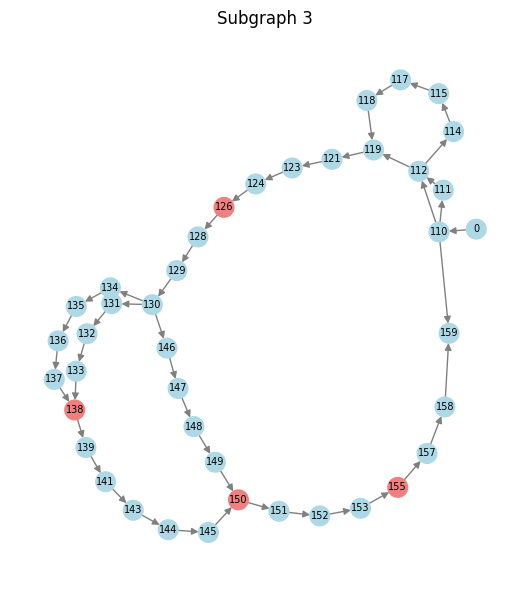

In [12]:
# draw_subgraphs(graph)
draw_subgraphs(graph, sub=subgraph_to_plot)
# draw_subgraphs(graph, sub='all')

# Timeline

In [2]:
def make_schedule(graph, xlim_start=None, xlim_end=None):
    data = {
        'task': [],
        'start': [],
        'end': [],
        'label': []  # Labels for the blocks
    }

    # for stack in graph.stack_list[:100]:
    for stack in graph.stack_list[1:]:
        data['task'].append(stack.hardware_selection)
        data['start'].append(stack.start_time)
        data['end'].append(stack.start_time + stack.cost_stack[stack.func_selection])
        data['label'].append(stack.oppid)



    df = pd.DataFrame(data)

    if xlim_start is not None and xlim_end is not None:
        df = df[(df['start'] >= xlim_start) & (df['end'] <= xlim_end)]

    unique_combinations = df[['task', 'label']].drop_duplicates()
    colors = plt.cm.get_cmap('tab10', len(unique_combinations))

    color_map = {}
    for idx, (task, label) in enumerate(unique_combinations.itertuples(index=False)):
        color_map[(task, label)] = colors(idx)


    fig, ax = plt.subplots(figsize=(30, 3))

    # Iterate over each row in the dataframe and plot a horizontal line
    for index, row in df.iterrows():
        task_label = (row['task'], row['label'])
        task_color = color_map[task_label]
        ax.hlines(y=row['task'], xmin=row['start'], xmax=row['end'], color=task_color, linewidth=35)

        # Adding label on the bar
        label_text = f"{row['label']}"
        ax.text((row['start'] + row['end']) / 2, row['task'], label_text, color='black', ha='center', va='center')

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Task')
    ax.set_title('Task Schedule')
    ax.grid(True)
    # ax.legend()

    # if xlim_start is not None and xlim_end is not None:
    #     ax.set_xlim(xlim_start, xlim_end)


    plt.show()
#

In [3]:
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0, 'CPU3': 0, 'CPU4': 0}, 'PHU': {'PHU1': 0, 'PHU2': 0, 'PHU3': 0} }
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0, 'CPU3': 0, 'CPU4': 0}, 'PHU': {'PHU1': 0, 'PHU2': 0} }
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0, 'CPU3': 0, 'CPU4': 0}, 'PHU': {'PHU1': 0} }

# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0}, 'PHU': {'PHU1': 0, 'PHU2': 0, 'PHU3': 0} }
# available_hardware = {'CPU': {'CPU1': 0}, 'PHU': {'PHU1': 0, 'PHU2': 0, 'PHU3': 0} }
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0, 'CPU3': 0, 'CPU4': 0}, 'PHU': {'PHU1': 0} }
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0, 'CPU3': 0}, 'PHU': {'PHU1': 0} }
# available_hardware = {'CPU': {'CPU1': 0, 'CPU2': 0,}, 'PHU': {'PHU1': 0} }
available_hardware = {'CPU': {'CPU1': 0,}, 'PHU': {'PHU1': 0} }

# dijk.scheduling_dijkstra(subgraphs[subgraph_to_plot], available_hardware=available_hardware)
# make_schedule(subgraphs[subgraph_to_plot])

end_time=0.07975638839999977


/tmp/ipykernel_3482421/1616729232.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_combinations))


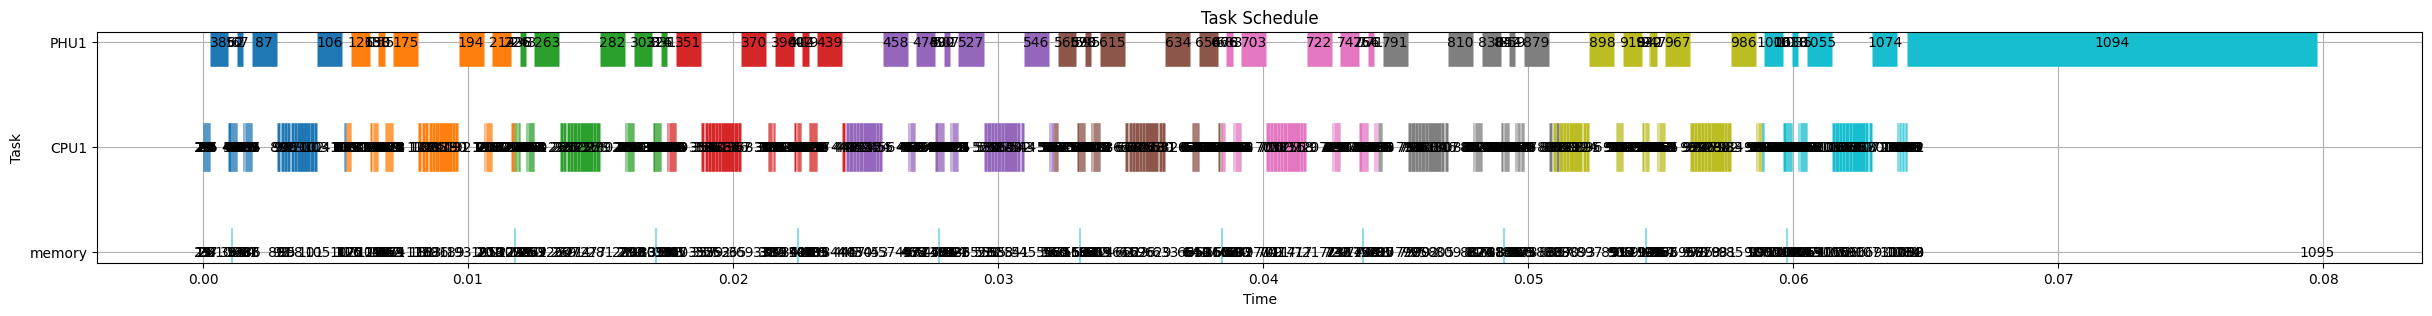

In [4]:

read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict


graph = sg.StackedGraph(raw_json=raw_json)
# gv.adj_to_graph(graph.adj_matrix, save=True, layout = 'spectral')
subgraphs = list(dijk.graph_partition(graph))
dijk.select_nodes(graph, subgraphs)
end_time = dijk.schdeule_nodes(graph, subgraphs)

print(f'{end_time=}')

make_schedule(graph, xlim_start=None, xlim_end=None)
# make_schedule(graph, xlim_start=0, xlim_end=0.01)


# Memory

In [2]:
def create_schedule_data(graph):
    data = {
        'hardware': [],
        'start': [],
        'end': [],
        'label': []  # Labels for the blocks
    }

    # for stack in graph.stack_list[16:-6]:
    for stack in graph.stack_list[1:]:
        data['hardware'].append(stack.hardware_selection)
        data['start'].append(stack.start_time)
        data['end'].append(stack.start_time + stack.cost_stack[stack.func_selection])
        data['label'].append(stack.oppid)

    df = pd.DataFrame(data)
    return df

In [3]:
read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict


graph = sg.StackedGraph(raw_json=raw_json)
# gv.adj_to_graph(graph.adj_matrix, save=True, layout = 'spectral')
subgraphs = list(dijk.graph_partition(graph))
dijk.select_nodes(graph, subgraphs)
end_time = dijk.schdeule_nodes(graph, subgraphs)

print(f'{end_time=}')
schedule_data = create_schedule_data(graph)

dram, sram = dijk.get_memory_profile(graph, schedule_data)

print(len(dram))
print(len(sram))

# for i in dram:
#     if i[1] == 0:
#         print(i)

# print(dram[-10:])

end_time=0.07975638839999977
dram_total=237892
sram_total=0
312
2190


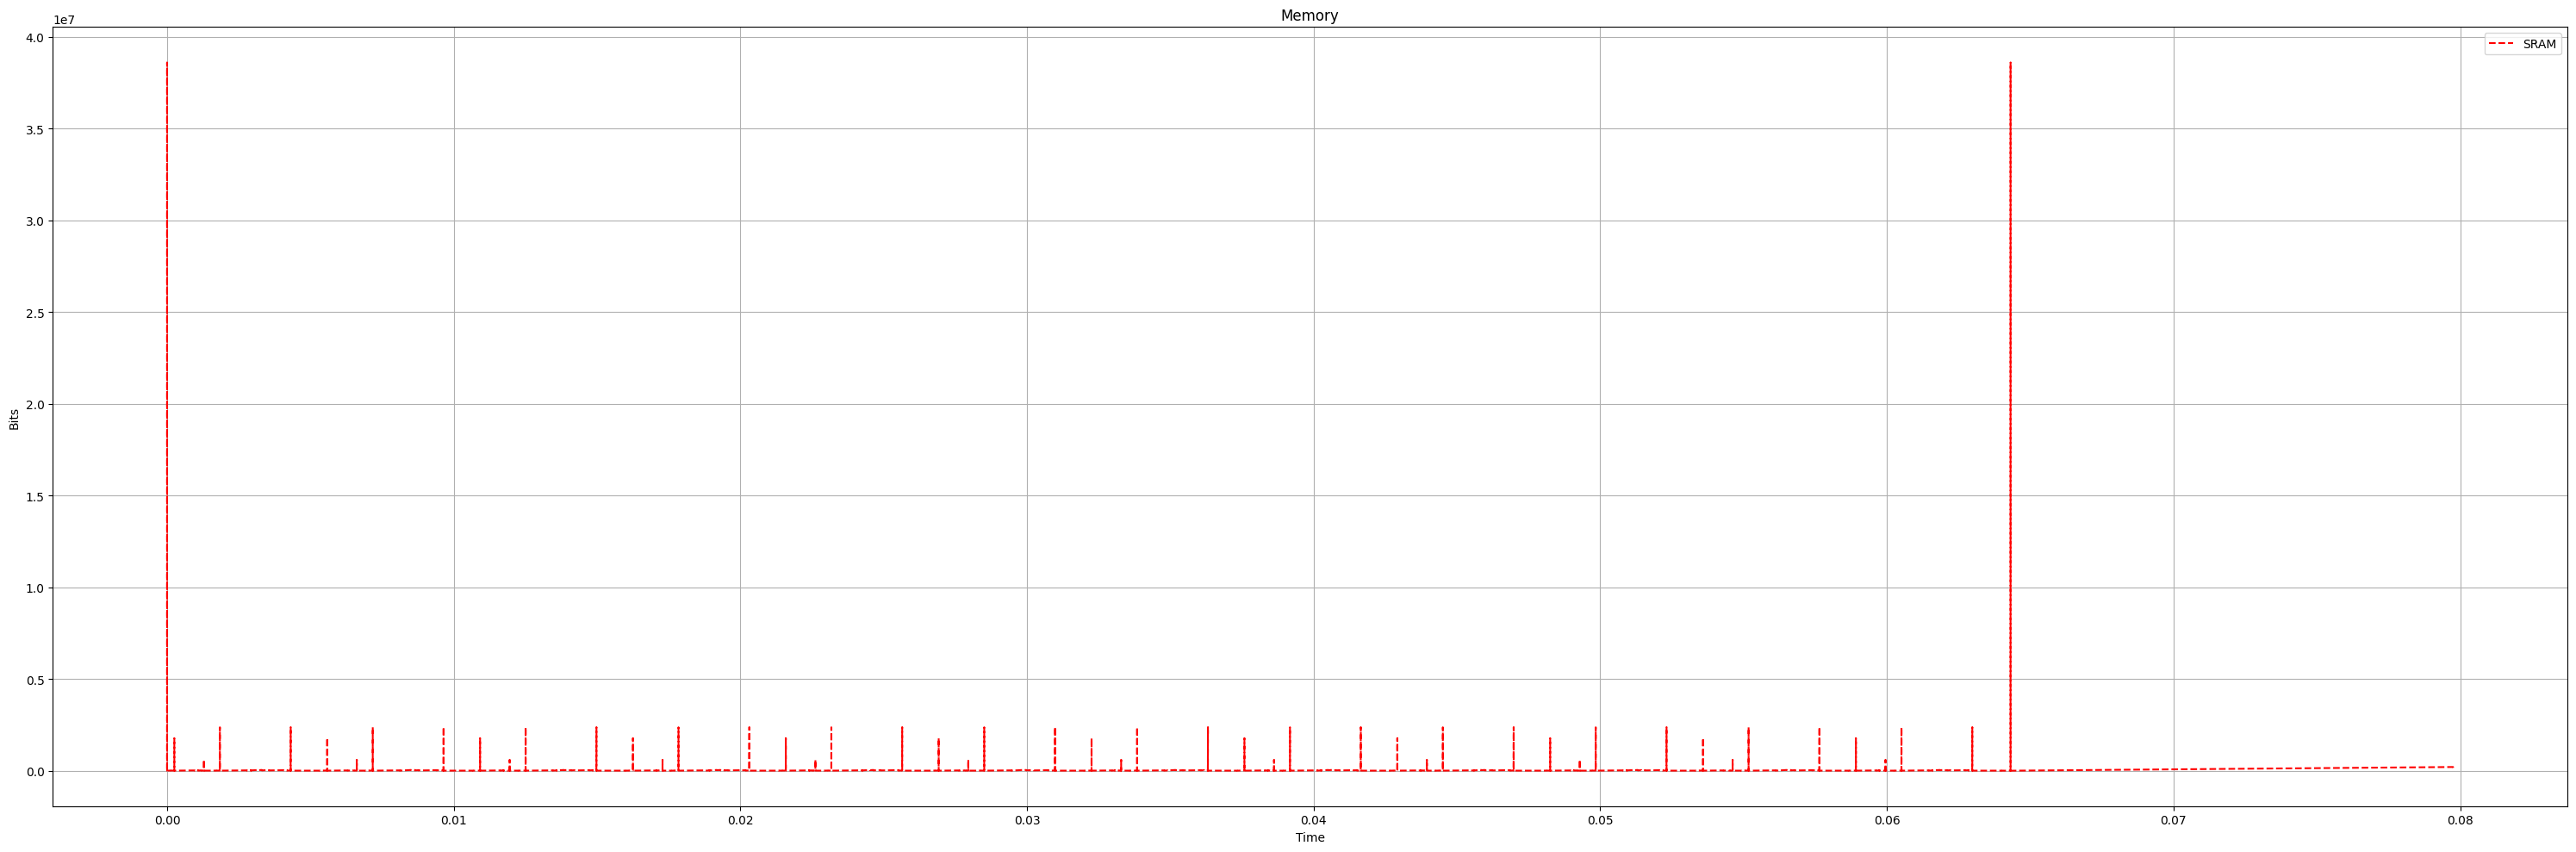

In [4]:
dram_t, dram_v = zip(*dram)
sram_t, sram_v = zip(*sram)


plt.figure(figsize=(30, 10))  # Optional: Adjust figure size

plt.plot(dram_t, dram_v, linestyle='-', color='b', label='DRAM')
plt.plot(sram_t, sram_v, linestyle='--', color='r', label='SRAM')

plt.xlabel('Time')
plt.ylabel('Bits')
plt.title('Memory')
plt.legend()

# plt.yscale('symlog')

plt.grid(True)
plt.tight_layout()

plt.show()